<center> 
    <div style="font-size: 40px;">
        <strong>
            <U>Projet IA HumanForYou </U>
        </strong>
    </div>
</center>

<br>

<center> <img src="images/cesi.jfif" /> </center>


<center> 
    GIRARD-TISSIER Ugo
     | 
    GISLARD Enzo
     | 
    GUESMIA Abdelrahmane
     | 
    CASENOVE Antoine
</center>

In [1]:
#import généraux
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sommaire

* Introduction
* Préparation des données
* Choix d'un modèle de machine learning
* Mesure de la performance : Courbe ROC
* Paramétrage des meilleurs modèles : RandomizedSearchCV
* Test des modèles
* Étude des résultats

# 1. Introduction

L'entreprise HumanForYou subit un turn-over d'environ 15% de ses employés (4000) chaque années.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets prennent du retard.

* Un service de ressources humaines de taille conséquente.

* Temps perdu à l'arrivée des nouveaux employés.

#### Objectif du projet :

* Déterminer les facteurs de turn-over
* Proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

#### Solution réalisée :

* Modèle prédictif de classification binaire
* Étude des facteurs de turn-over selon notre modèle

# 2. Préparation des données

### A. Chargement des jeux de données

Les données fournies par HumanForYou ont, dans un premier temps, été téléchargées et placées dans le répertoire `datasets`.

Nous allons maintenant créer une fonction utilisant [`Pandas`](https://pandas.pydata.org/) qui s'occupe de charger les données en mémoire dans un `Pandas DataFrame`.

In [2]:
import os

def load_datasets(path, file_name):
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

Il est maintenant possible de charger nos données pour chaque fichier CSV transmis par HumanForYou

In [3]:
general_data = load_datasets("datasets", "general_data.csv")
manager_survey_data = load_datasets("datasets", "manager_survey_data.csv")
employee_survey_data = load_datasets("datasets", "employee_survey_data.csv")
in_time_data = load_datasets("datasets", "in_time.csv")
out_time_data = load_datasets("datasets", "out_time.csv")

Nous allons afficher les premières lignes de nos diffèrents tableaux `Pandas` pour en faire une première approche

In [4]:
general_data.head(2).style

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.000000,Y,11,8,0,1.000000,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.000000,Y,23,8,1,6.000000,3,5,1,4


In [5]:
manager_survey_data.head(2).style

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4


In [6]:
employee_survey_data.head(2).style

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.000000,4.000000,2.000000
1,2,3.000000,2.000000,4.000000


In [7]:
in_time_data.head(2).style

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,nan,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,nan,2015-01-15 10:01:24,2015-01-16 10:19:08,nan,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,nan,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,nan,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,nan,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,nan,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,nan,2015-03-27 09:47:30,2

In [8]:
out_time_data.head(2).style

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,nan,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,nan,2015-01-15 17:22:13,2015-01-16 17:35:11,nan,2015-01-20 16:37:07,2015-01-21 16:55:24,2015-01-22 16:50:47,2015-01-23 17:00:01,nan,2015-01-27 17:28:22,2015-01-28 17:03:21,2015-01-29 17:18:36,2015-01-30 17:00:25,2015-02-02 16:32:49,2015-02-03 17:35:49,2015-02-04 17:24:56,2015-02-05 17:26:31,2015-02-06 17:21:35,2015-02-09 17:37:50,2015-02-10 17:30:20,2015-02-11 17:30:19,2015-02-12 17:36:42,2015-02-13 16:25:26,2015-02-16 17:50:23,2015-02-17 17:28:06,2015-02-18 18:13:29,nan,2015-02-20 17:44:52,2015-02-23 17:13:27,2015-02-24 17:24:48,2015-02-25 17:27:37,2015-02-26 17:08:36,2015-02-27 17:21:55,2015-03-02 17:29:08,2015-03-03 16:54:12,2015-03-04 17:50:18,nan,2015-03-06 17:44:47,2015-03-09 17:53:05,2015-03-10 16:42:53,2015-03-11 16:58:39,2015-03-12 17:15:39,2015-03-13 17:25:55,nan,2015-03-17 17:00:16,2015-03-18 17:40:13,2015-03-19 17:52:44,2015-03-20 17:47:34,2015-03-23 17:48:18,2015-03-24 17:48:26,2015-03-25 17:08:19,nan,2015-03-27 17:20:51,2

### B. Construction d'un unique dataset

Pour éviter de se compliquer la tache, il est preferable de travailler avec un seul et unique dataset. Or l'entreprise nous a transmis des jeux de données qui sont liés à leurs employés. Nous allons donc essayer de "joindre" ces jeux de données en un seul tableau.

Nous vérifions dans un premier si nos tableaux `Pandas` contiennent le même nombre de ligne

In [9]:
print("Dimensions general_data :", general_data.shape)
print("Dimensions manager_survey_data :", manager_survey_data.shape)
print("Dimensions employee_survey_data :", employee_survey_data.shape)
print("Dimensions in_time_data :", in_time_data.shape)
print("Dimensions out_time_data :", out_time_data.shape)

Dimensions general_data : (4410, 24)
Dimensions manager_survey_data : (4410, 3)
Dimensions employee_survey_data : (4410, 4)
Dimensions in_time_data : (4410, 262)
Dimensions out_time_data : (4410, 262)


Bonne nouvelle! Les tableaux contiennent tous le même nombre de ligne. Il semblerait que nous ayons donc une ligne par employé dans chaque tableau. 

Nous pouvons commencer par essayer de "joindre" les tableaux `general_data` et `manager_survey_data`. En effet, ces deux tableaux ont une colonne similaire nommée `EmployeeID` qui semble la plus adaptée à une jointure. 

Avant de faire la jointure, nous allons vérifier qu'il n'y a pas de doublons sur cette donnée car cela pourrait planter notre jointure.

In [10]:
print("Nombre de ligne unique general_data : ", general_data.EmployeeID.unique().shape)
print("Nombre de ligne unique manager_survey_data : ", manager_survey_data.EmployeeID.unique().shape)

Nombre de ligne unique general_data :  (4410,)
Nombre de ligne unique manager_survey_data :  (4410,)


Parfait, le nombre d'élément unique est le même, nous pouvons faire la jointure sur cette colonne

In [11]:
dataset = general_data.join(manager_survey_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
print ("Dimensions après jointure : ", dataset.shape)

Dimensions après jointure :  (4410, 26)


Nous obtenons bien le même nombre de ligne et nous avons bien les 24 colonnes de `general_data` plus les 2 colonnes de `manager_survey_data` (`EmployeeID` n'ayant été gardée qu'une seule fois lors de la jointure) 

Nous pouvons maintenant réexécuter cette procédure avec les tableaux `dataset` et `employee_survey_data`

In [12]:
print("Nombre de ligne unique employee_survey_data : ", employee_survey_data.EmployeeID.unique().shape)

Nombre de ligne unique employee_survey_data :  (4410,)


In [13]:
dataset = dataset.join(employee_survey_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
print ("Dimensions après jointure : ", dataset.shape)

Dimensions après jointure :  (4410, 29)


Les tableaux `in_time_data` et `out_time_data` ne contiennent pas de colonne nommée `EmployeeID`. Cependant la première colonne de ces deux tableaux y ressemble beaucoup. Nous allons vérifier si celle-ci contient des données uniques, si oui alors nous utiliserons cette colonne en tant qu'ID de jointutre.

In [14]:
in_time_data.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
out_time_data.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
print("Nombre de ligne unique in_time_data : ", in_time_data.EmployeeID.unique().shape)
print("Nombre de ligne unique out_time_data : ", out_time_data.EmployeeID.unique().shape)

Nombre de ligne unique in_time_data :  (4410,)
Nombre de ligne unique out_time_data :  (4410,)


In [15]:
dataset = dataset.join(in_time_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
dataset = dataset.join(out_time_data.set_index('EmployeeID'), how="inner", on="EmployeeID", lsuffix='_in', rsuffix='_out')

In [16]:
dataset.head().style

Notre variable `dataset` est maintenant le résultat de la jointure de tout les tableaux fournit par HumanForYou, ce qui sera beaucoup plus simple à exploiter pour plus tard.

### C. Exploration du jeu de données

Nous allons, dans cette partie, étudier plus en détails les données qui nous ont été fournies par l'entreprise. Dans un premier temps nous allons nous focaliser sur les données 28 premières colonnes et ainsi éliminer toutes les colonnes liées aux entrées / sorties des employés pour "allèger" notre dataset.

In [17]:
dataset_without_in_out = dataset.drop(dataset.iloc[:,29:],1)
dataset_without_in_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

#### C.1 Question d'éthique

La première question à traiter avant tout travail sur un dataset est bien évidemment la question de `l'éthique`. En effet, nous ne pouvons pas nous permettre de travailler sur des données pouvant amener à des conflits basés sur l'éthique.

Ainsi, bien que certaines de ces données peuvent peut être jouer un rôle important dans notre étude, nous décidons de supprimer les colonnes suivantes pour éviter tout problème :

* Gender
* MaritalStatus            

In [18]:
dataset_without_in_out.drop("Gender", axis=1, inplace=True)
dataset_without_in_out.drop("MaritalStatus", axis=1, inplace=True)

#### C.2 Recherche des données inutiles

Nous allons commencer par afficher un `histogramme` par attribut numérique.

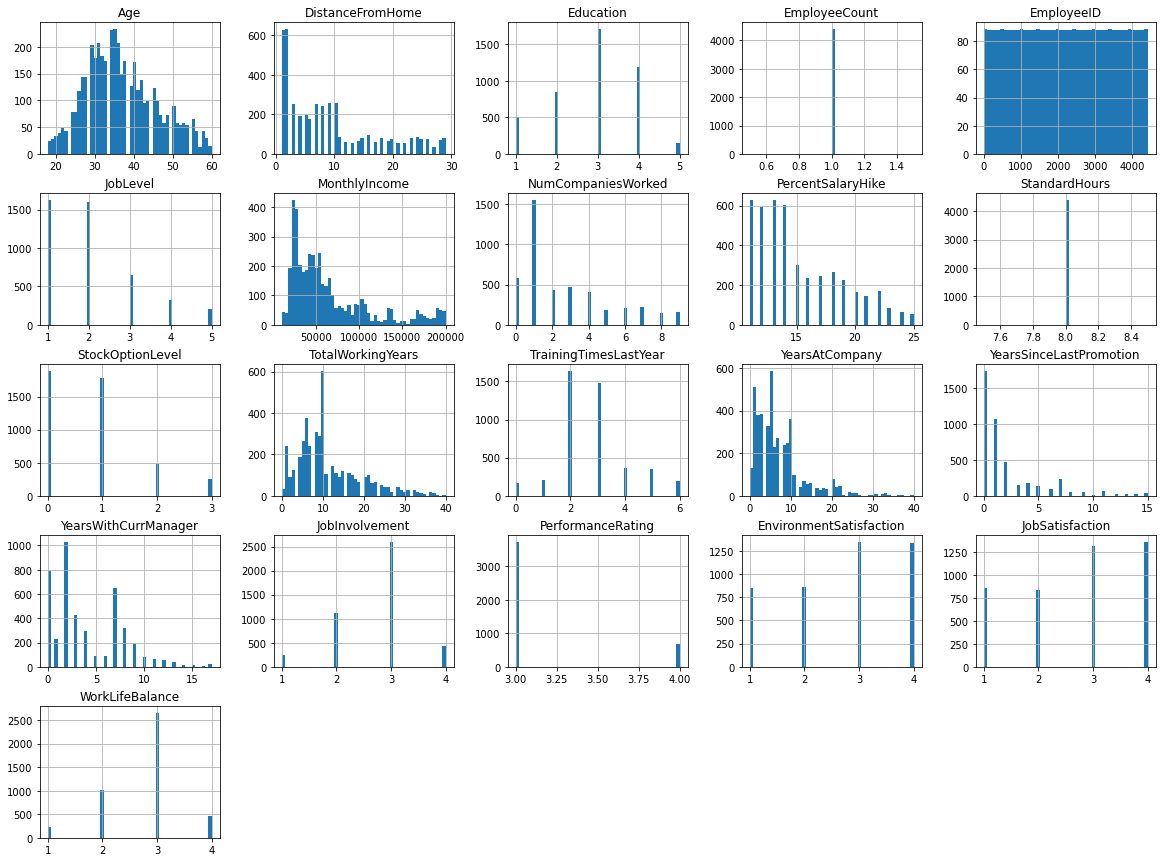

In [19]:
dataset_without_in_out.hist(bins=50, figsize=(20,15))
plt.show()

#### Remarques :

* `EmployeeID` n'a pas d'intéret dans notre jeu de données. Cette colonne est un simple identifiant, un algorithme de machine learning n'en tirera rien.


* On peut voir ici que `EmployeeCount` ne semble pas être une donnée pertinente. En effet l'ensemble des employées était présent en 2015, cela n'aura donc aucun impact sur la prédiction que l'on souhaite faire. Si l'ensemble des employées est "regroupé" sous une même valeurs, cela signifie que cette données est inutile pour notre modèle.


* Il en est de même pour la donnée `StandardHours`. Celle-ci ne semble avoir aucune pertinence puisque l'ensemble des employés ont tous le même nombre d'heures à effectuer au sein d'une journée.


* `PerformanceRating` possède deux "classes" bien distinctes. En effet l'ensemble des données sont regroupées sous deux valeurs : 3 et 4, il serait peut être intéressant de savoir si cette données à un impact direct sur l'attrition.


* Les colonnes `WorkLifeBalance` et `JobInvolvement` ont quasiment les mêmes historgrammes. Il en est de même pour `JobSatisfaction` et `EnvironmentSatisfaction`. Nous allons donc verifier si il existe des corrélations entre ces colonnes.


* Certaines données comme `YearSinceLastPromotion` & `DistanceFromHome` semblent intéressantes à étudier. En effet, on peut voir que beaucoup de personnes qui habitent loin de leur lieu de travail et beaucoup ont été promus récemment, ces données ont potentiellement un impact sur le turn over au sein de la société.


* La colonne `Age` semble ne pas descendre en dessous de 18 ans. Nous allons vérifier cela avec la colonne `Over18` qui est quand à elle une donnée qualitative. Si c'est le cas, alors nous pourrons supprimer la colonne `Over18` car elle ne servirait à rien pour notre modèle.


* Les échelles sont très différentes d'une feature à l'autre. Un scaling sera nécessaire pour obtenir un modèle performant.

Nous pouvons donc supprimer les colonnes `EmployeeID`, `EmployeeCount` et `StandardHours` car elles n'ont pas d'intérêt :

In [20]:
dataset_without_in_out.drop("EmployeeID", axis=1, inplace=True) 
dataset_without_in_out.drop("EmployeeCount", axis=1, inplace=True) 
dataset_without_in_out.drop("StandardHours", axis=1, inplace=True) 

Vérifions maintenant la colonne `Over18` :

In [21]:
dataset_without_in_out["Over18"].value_counts()

Y    4410
Name: Over18, dtype: int64

Nous avons vu juste, les 4410 valeurs sont toutes les mêmes dans cette colonne. Nous pouvons la supprimer.

In [22]:
dataset_without_in_out.drop("Over18", axis=1, inplace=True) 

Les colonnes suivantes ont donc été supprimées du dataset :

* EmployeeID
* EmployeeCount
* StandardHours
* Over18

In [23]:
dataset_without_in_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MonthlyIncome            4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  PercentSalaryHike        4410 non-null   int64  
 12  StockOptionLevel         4410 non-null   int64  
 13  TotalWorkingYears        4401 non-null   float64
 14  TrainingTimesLastYear   

#### C.3 Étude des horaires d'entrées / sorties

Les données d'entrées / sorties fournies par les badgeuses de l'entreprise sont assez indigestes et n'ont pas de valeur significative pour un algorithme de machine learning dans leur forme actuelle. Nous avons donc décidé d'essayer de faire une moyenne du nombre d'heure travaillées, par jour, d'un employé entre le `01/01/2015` et le `31/12/2015`

Nous commencons par récuperer un tableau contenant uniquement les données d'entrées / sorties depuis notre `dataset`

In [24]:
dataset_with_in_out = dataset.drop(dataset.iloc[:, 0:29],1)

Nous allons maintenant transformer toutes ces données étant de type `string` en `datetime`

In [25]:
dataset_with_in_out = dataset_with_in_out.apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
dataset_with_in_out.head()

,2015-01-01_in,2015-01-02_in,2015-01-05_in,2015-01-06_in,2015-01-07_in,2015-01-08_in,2015-01-09_in,2015-01-12_in,2015-01-13_in,2015-01-14_in,...,2015-12-18_out,2015-12-21_out,2015-12-22_out,2015-12-23_out,2015-12-24_out,2015-12-25_out,2015-12-28_out,2015-12-29_out,2015-12-30_out,2015-12-31_out
0,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaT,...,NaT,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaT,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,NaT,2015-01-02 10:15:44,2015-01-05 10:21:05,NaT,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,NaT,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaT,NaT,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,NaT,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,NaT,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaT,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,NaT,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,NaT,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaT,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,NaT,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,NaT,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaT,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


Il est maintenant nécessaire de "soustraire" les sorties des entrées des employés pour obtenir le temps qu'ils ont passés, par jour, sur leur lieu de travail

In [26]:
import datetime as dt
import pandas as pd

nombre_de_jour = int(dataset_with_in_out.shape[1] / 2)

datetime_in = dataset_with_in_out.drop(dataset_with_in_out.iloc[:, nombre_de_jour:],1)
datetime_out = dataset_with_in_out.drop(dataset_with_in_out.iloc[:, :nombre_de_jour],1)

datetime_in.columns = datetime_in.columns.str.rstrip("_in")
datetime_out.columns = datetime_out.columns.str.rstrip("_out")

datetime_sub = datetime_out.subtract(datetime_in, fill_value=0)

Moyenne du temps que chaque employés à passé sur son lieu de travail par jour entre le `01/01/2015` et le `31/12/2015`, en secondes :

In [27]:
datetime_mean = datetime_sub.mean(axis = 1)
datetime_mean = datetime_mean.dt.total_seconds()
datetime_mean

0       26545.142241
1       27788.288136
2       25247.665289
3       25897.242553
4       28822.228571
            ...     
4405    30680.197531
4406    21934.634855
4407    27743.874459
4408    34173.340249
4409    25160.211207
Length: 4410, dtype: float64

Les données d'entrées et de sorties sont maintenant beaucoup plus exploitable par un algorithme de machine learning. Nous allons donc les remettres dans notre `dataset`.

In [28]:
final_dataset = dataset_without_in_out
final_dataset["MoyenneInOut"] = datetime_mean

final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MonthlyIncome            4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  PercentSalaryHike        4410 non-null   int64  
 12  StockOptionLevel         4410 non-null   int64  
 13  TotalWorkingYears        4401 non-null   float64
 14  TrainingTimesLastYear   

#### C.4 Préparation de la variable cible

Avant de découper notre dataset en jeu d'entrainement et de test, nous allons préparer la variable cible `Attrition` pour qu'elle soit interprétable par notre model. En effet, cette varaible binaire contient deux valeurs qui sont "Yes" et "No". Nous allons ainsi convertir ces chaînes de caractères en chiffres.

In [29]:
final_dataset['Attrition'] = final_dataset['Attrition'].replace(['Yes','No'], [1, 0])

Nous pouvons aussi vérifier les proportions de Yes et No dans notre `dataset` :

In [30]:
print(final_dataset['Attrition'].value_counts())
print("Le nombre de Yes est de", (711/4410) * 100, "%")

0    3699
1     711
Name: Attrition, dtype: int64
Le nombre de Yes est de 16.122448979591837 %


#### C.5 Création des jeux d'entrainement et de test

Nous allons découper notre jeu de données en deux :

* Le `train_set` contiendra 80% de nos données.
* Le `test_set` contiendra 20% de nos données.

##### Échantillonage stratifié sur `Attrition` :

<AxesSubplot:>

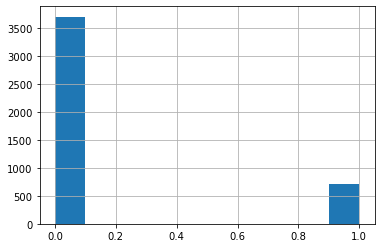

In [31]:
final_dataset["Attrition"].hist()

On peut maintenant utiliser [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) pour échantillonner le jeu de données en respectant notre contrainte :

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #initialise le split

for train_index, test_index in split.split(final_dataset, final_dataset["Attrition"]): 
    train_set = dataset_without_in_out.loc[train_index]
    test_set = dataset_without_in_out.loc[test_index]

##### Proportions de `Attrition` sur le `train_set` et le `test_set` :

<AxesSubplot:>

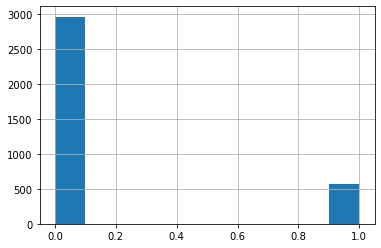

In [33]:
train_set["Attrition"].hist()

<AxesSubplot:>

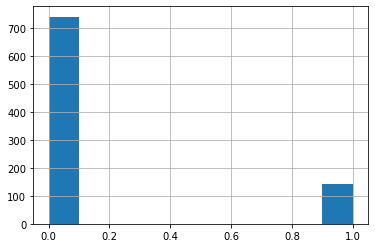

In [34]:
test_set["Attrition"].hist()

Nos histrogrammes semblent avoir les mêmes proportions. Notre stratification a donc bien fonctionnée.

### D. Préparation des données d'entrainement pour les algorithmes de ML

Nous allons commencer par scinder le jeu de données d'entrainement. D'une part nous aurons, les variables-cibles, ou "labels", notées $Y$ et de l'autre, les "features" notées $X$.

In [35]:
train_set_features = train_set.drop("Attrition", axis=1)
train_set_labels = train_set["Attrition"].copy()
train_set_features

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MoyenneInOut
3465,41,Travel_Rarely,Sales,1,4,Life Sciences,1,Research Director,52570,1.0,...,2,10,0,8,4,3,2.0,3.0,3.0,28474.904564
3485,34,Non-Travel,Sales,1,1,Marketing,2,Research Director,26960,3.0,...,3,0,0,0,3,4,3.0,4.0,3.0,25505.516667
3052,21,Travel_Rarely,Human Resources,10,2,Human Resources,1,Laboratory Technician,53730,1.0,...,2,1,0,0,3,3,3.0,2.0,3.0,21523.119342
2012,28,Travel_Frequently,Research & Development,7,3,Life Sciences,2,Manager,29760,1.0,...,3,1,0,0,3,3,1.0,2.0,3.0,22612.540084
426,40,Travel_Rarely,Research & Development,1,4,Medical,2,Research Scientist,192320,2.0,...,3,1,0,0,3,3,1.0,2.0,2.0,21838.106195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,37,Travel_Rarely,Research & Development,20,5,Life Sciences,2,Manager,68040,4.0,...,1,3,0,2,3,3,1.0,3.0,3.0,27079.943478
613,24,Travel_Rarely,Human Resources,28,4,Human Resources,3,Manufacturing Director,28860,1.0,...,5,1,0,0,3,3,4.0,2.0,1.0,23624.911894
808,33,Travel_Rarely,Research & Development,7,2,Life Sciences,2,Research Scientist,37370,8.0,...,2,5,0,2,3,4,1.0,2.0,3.0,28434.741803
2946,28,Travel_Rarely,Research & Development,11,2,Medical,2,Sales Executive,58130,2.0,...,2,0,0,0,3,4,1.0,3.0,1.0,24823.072034


#### D.1 Identifications des données numériques et qualitative

In [36]:
train_set_features_num = train_set_features.select_dtypes(include=[np.number]) 
train_set_features_cat = train_set_features.select_dtypes(exclude=[np.number])

train_set_features_num = list(train_set_features_num)
train_set_features_cat = list(train_set_features_cat)

train_set_features_cat

['BusinessTravel', 'Department', 'EducationField', 'JobRole']

#### D.2  Pipeline des données qualitatives

In [37]:
from sklearn.pipeline import Pipeline

cacacaca

In [38]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder())
])

#### D.2  Pipeline des données numériques

cacacaca

In [39]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#### D.3  Pipeline de préparation des données

In [40]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, train_set_features_num),
        ("cat", cat_pipeline, train_set_features_cat),
    ])

In [41]:
train_set_features_prepared = full_pipeline.fit_transform(train_set_features)

In [42]:
train_set_features_cat = full_pipeline.named_transformers_['cat']['cat_encoder'].get_feature_names(train_set_features_cat)
train_set_features_cat = list(train_set_features_cat)

##### Données préparées :

In [43]:
train_set_features_prepared_pd = pd.DataFrame(
    train_set_features_prepared,
    columns = train_set_features_num + train_set_features_cat)

train_set_features_prepared_pd.head().style

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MoyenneInOut,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0.463140,-1.016618,1.055180,-0.969757,-0.259638,-0.679818,-0.341374,-0.939036,-0.160786,-0.615667,0.508815,-0.677208,1.098882,1.797989,-0.432065,-0.661977,0.263919,0.337770,0.154623,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,-0.306868,-1.016618,-1.876060,-0.068228,-0.801808,0.119915,2.102113,-0.939036,-0.676822,0.162575,-1.149782,-0.677208,-1.146292,0.381440,2.314467,0.257856,1.169667,0.337770,-0.460246,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,-1.736884,0.087413,-0.898980,-0.969757,-0.235080,-0.679818,-0.884371,0.234094,-1.321867,-0.615667,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,0.257856,-0.641828,0.337770,-1.284879,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.966876,-0.280597,0.078100,-0.068228,-0.742531,-0.679818,-0.341374,-0.939036,-1.321867,0.162575,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,-1.581810,-0.641828,0.337770,-1.059293,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.353139,-1.016618,1.055180,-0.068228,2.698904,-0.279952,-0.341374,0.234094,-0.031777,0.162575,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,-1.581810,-0.641828,-1.094505,-1.219655,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


##### Boites à moustache :

Les diagrammes en boîtes (ou boites à moustache) nous permettent de visualiser la répartition des données au niveau de chaque features et mettre notamment en évidences la présebce de valeurs aberrantes. On remarque ici que malgré l'utilisation de méthodes permettent de réduire le nombre de valeurs aberrantes on obtient tout de même quelques valeurs aberrantes pour certaines features.

<AxesSubplot:>

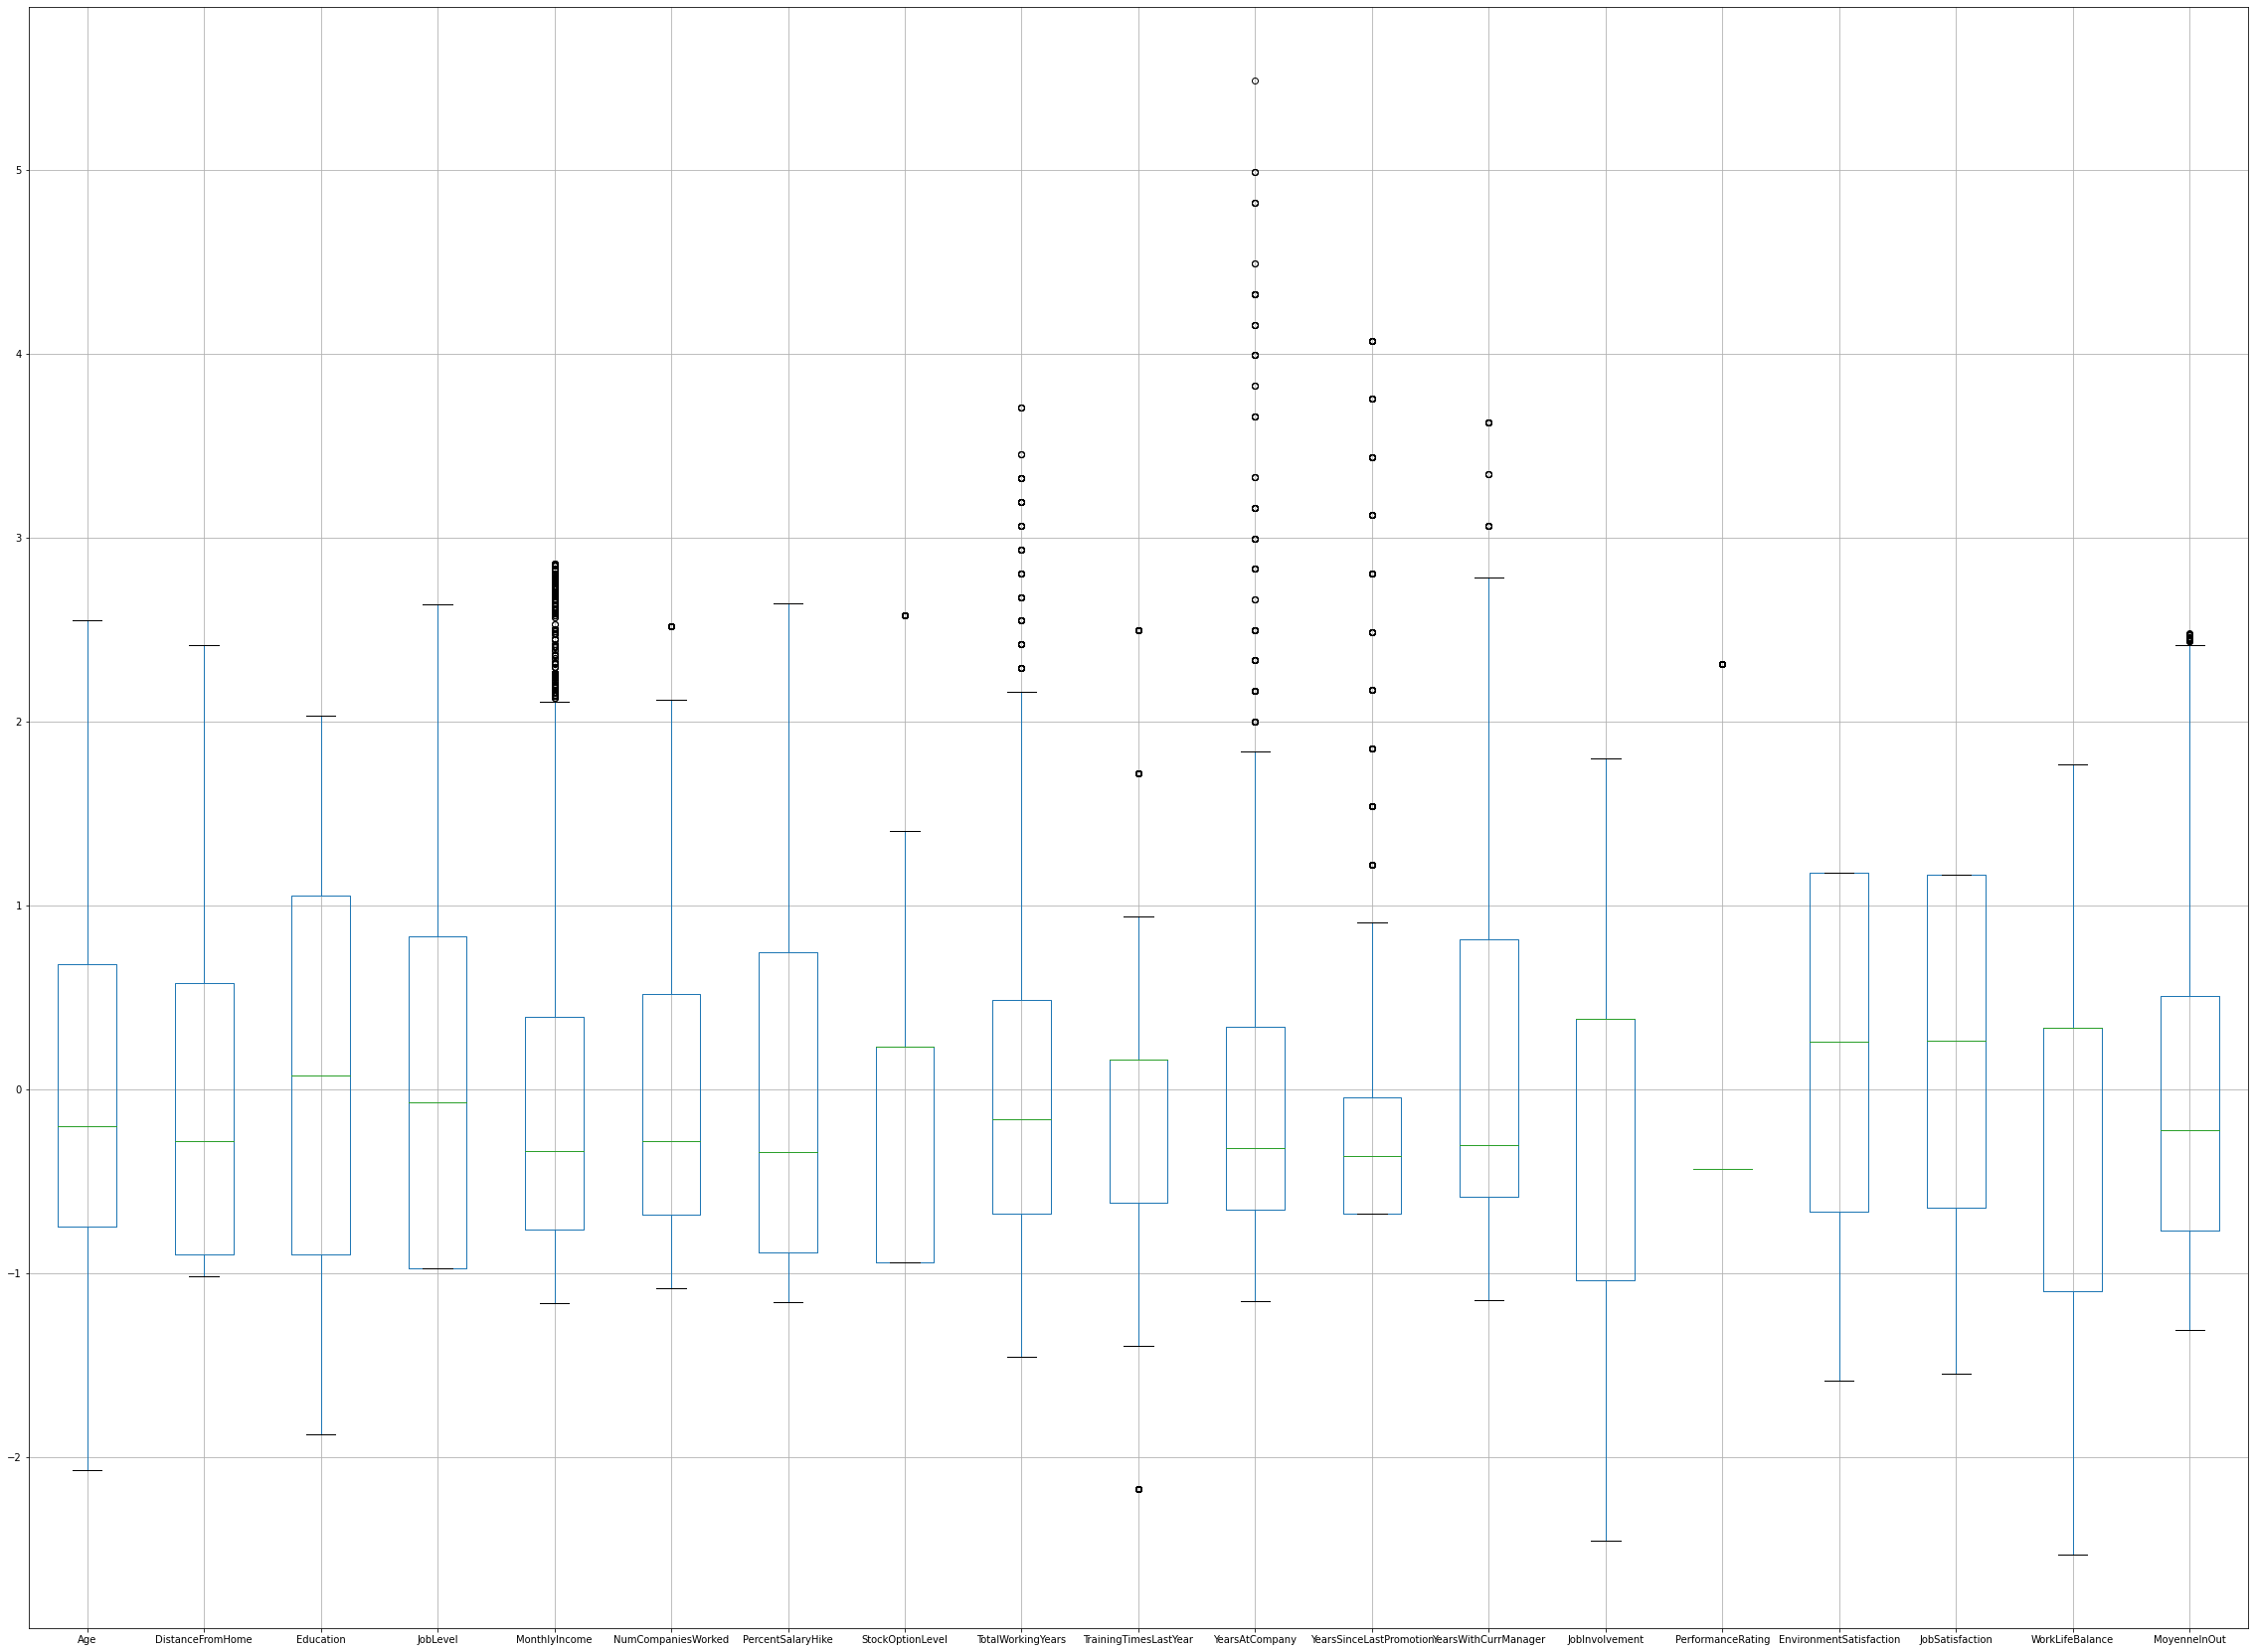

In [44]:
train_set_features_prepared_pd.boxplot(train_set_features_num, figsize=(40,30))

#### D.4  Etude de corrélation

Maintenant que nos données qualitatif sont transformées, nous pouvons effectuer une étude de la corrélation sur la totalité des features (qualitatif + quantitatif). 

Nous allons tout d'abord réassembler les features avec le label `Attrition`

In [45]:
train_set_labels_pd = pd.DataFrame(train_set_labels)
result_train_set = train_set_features_prepared_pd.copy()

result_train_set["Attrition"] = train_set_labels_pd

print(train_set_labels_pd.shape)
print(train_set_features_prepared_pd.shape)
print(result_train_set.shape)

result_train_set.head().style

(3528, 1)
(3528, 40)
(3528, 41)


,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MoyenneInOut,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Attrition
0,0.463140,-1.016618,1.055180,-0.969757,-0.259638,-0.679818,-0.341374,-0.939036,-0.160786,-0.615667,0.508815,-0.677208,1.098882,1.797989,-0.432065,-0.661977,0.263919,0.337770,0.154623,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,-0.306868,-1.016618,-1.876060,-0.068228,-0.801808,0.119915,2.102113,-0.939036,-0.676822,0.162575,-1.149782,-0.677208,-1.146292,0.381440,2.314467,0.257856,1.169667,0.337770,-0.460246,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
2,-1.736884,0.087413,-0.898980,-0.969757,-0.235080,-0.679818,-0.884371,0.234094,-1.321867,-0.615667,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,0.257856,-0.641828,0.337770,-1.284879,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan
3,-0.966876,-0.280597,0.078100,-0.068228,-0.742531,-0.679818,-0.341374,-0.939036,-1.321867,0.162575,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,-1.581810,-0.641828,0.337770,-1.059293,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.353139,-1.016618,1.055180,-0.068228,2.698904,-0.279952,-0.341374,0.234094,-0.031777,0.162575,-0.983923,-0.677208,-1.146292,0.381440,-0.432065,-1.581810,-0.641828,-1.094505,-1.219655,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


Nous pouvons désormais afficher la matrice de corrélation entre la totalité des features (et le label). Et ainsi observer les différents liens entre les features

In [46]:
corr_matrix = result_train_set.corr(method='spearman') 
corr_matrix_2 = result_train_set.corr(method='kendall') 

corr_matrix.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MoyenneInOut,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Attrition
Age,1.0,0.0034,-0.034,-0.01,-0.023,0.35,-0.034,-0.026,0.66,-0.058,0.24,0.17,0.18,0.02,-0.028,0.015,0.004,0.0021,-0.005,0.00049,-0.015,0.013,-0.0091,0.022,-0.019,-0.046,-0.017,-0.031,0.027,-0.01,0.049,-0.048,0.017,0.022,-0.0043,-0.0037,0.004,0.0022,0.024,-0.032,4.7e-05
DistanceFromHome,0.0034,1.0,-0.016,-0.025,-0.019,-0.041,0.04,0.013,-0.0044,0.015,0.013,0.0052,0.029,-0.032,0.039,0.022,-0.019,0.0088,0.014,-0.031,0.026,-0.0019,-0.032,-0.0033,0.018,0.018,0.0025,0.019,-0.0087,-0.022,-0.0015,-0.028,-0.00039,0.059,-0.052,0.012,-0.013,-0.011,-0.0067,0.022,0.033
Education,-0.034,-0.016,1.0,0.039,-0.0068,-0.0086,-0.034,-0.0091,0.022,0.038,0.012,0.028,0.026,-0.016,-0.035,-0.055,0.005,-0.021,0.0023,-0.0011,0.014,-0.011,0.012,-0.0056,0.00038,-0.026,0.003,-0.0032,-0.024,0.057,0.0045,-0.026,0.054,-0.076,0.036,-0.0059,0.046,-0.0017,0.0059,0.031,-0.0062
JobLevel,-0.01,-0.025,0.039,1.0,0.036,-0.013,0.041,-0.034,-0.031,-0.031,-0.043,-0.041,-0.039,-0.024,0.019,-0.029,-0.019,-0.018,-0.0084,-0.033,-0.0052,0.026,0.021,-0.043,0.035,0.0094,0.014,0.034,-0.046,0.0066,0.0051,0.03,0.026,-0.035,0.029,-0.00095,0.012,0.011,-0.014,-0.035,0.02
MonthlyIncome,-0.023,-0.019,-0.0068,0.036,1.0,-0.041,0.009,0.053,-0.017,0.019,0.019,0.054,0.019,0.022,0.0051,-0.004,-0.0013,0.027,-0.017,0.077,-0.055,-0.0034,-0.021,0.056,-0.049,-0.0069,0.015,-0.047,0.021,0.011,-0.016,-0.023,-0.023,0.017,-0.0094,0.046,0.0088,-0.0094,0.0095,-0.04,0.015
NumCompaniesWorked,0.35,-0.041,-0.0086,-0.013,-0.041,1.0,0.0054,0.04,0.32,-0.018,-0.17,-0.064,-0.15,0.021,-0.0071,0.022,-0.052,-0.012,-0.02,0.0027,-0.035,0.028,-0.042,0.05,-0.033,-0.028,0.0026,0.0035,-0.011,0.0081,0.016,0.02,0.037,-0.0016,-0.004,0.0066,0.019,-0.022,-0.017,-0.0041,-0.015
PercentSalaryHike,-0.034,0.04,-0.034,0.041,0.009,0.0054,1.0,0.014,-0.042,-0.033,-0.048,-0.034,-0.049,-0.022,0.63,-0.0017,0.025,-0.038,0.029,0.035,-0.0074,-0.017,-0.031,0.029,-0.016,-0.011,-0.013,-0.022,0.038,0.026,-0.031,0.025,-0.033,0.034,-0.0057,-0.01,-0.022,0.003,-0.044,0.054,-0.0017
StockOptionLevel,-0.026,0.013,-0.0091,-0.034,0.053,0.04,0.014,1.0,0.0084,-0.059,0.0021,0.0091,0.0035,0.0047,-0.036,0.0006,0.045,0.0021,-0.014,0.0079,-0.017,0.0093,0.014,-0.028,0.023,0.003,-0.046,-0.0097,0.068,-0.00063,-0.022,0.01,-0.025,0.0097,-0.081,0.029,-0.011,0.019,0.026,-0.026,-0.014
TotalWorkingYears,0.66,-0.0044,0.022,-0.031,-0.017,0.32,-0.042,0.0084,1.0,-0.053,0.58,0.32,0.48,-0.0095,-0.013,-0.0073,-0.0079,0.0077,-0.014,-0.028,-0.0081,0.025,-0.048,0.062,-0.042,-0.062,-0.0024,-0.013,0.015,-0.043,0.057,-0.017,0.034,0.018,-0.0048,-0.0069,0.018,-0.006,0.022,-0.068,-0.00064
TrainingTimesLastYear,-0.058,0.015,0.038,-0.031,0.019,-0.018,-0.033,-0.059,-0.053,1.0,-0.024,0.003,-0.022,-0.014,-0.028,0.036,-0.018,-0.017,-0.035,0.055,-0.016,-0.023,-0.027,0.004,0.008,-0.027,0.033,-0.0017,-0.0055,-0.054,0.012,-0.036,-0.033,-0.031,-0.014,-0.011,0.024,-0.017,0.07,0.032,-0.022


On remarque par exemple une forte corrélation entre `Age` et `TrainingTimesLastYear`. Traçons la courbe pour observer cette corrélation. Nous comparons deux variables discrète.

<AxesSubplot:xlabel='TotalWorkingYears', ylabel='Age'>

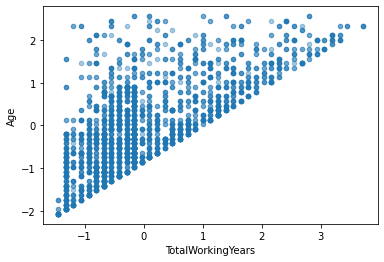

In [47]:
result_train_set.plot(kind="scatter", x="TotalWorkingYears", y="Age", alpha=0.4,
    sharex=False)

 Validons désormais certaines hypothèses de départ faites sur la corrélation entre certaines features :
 * Hypothèse 1 : "Il exsiste une corrélation entre WorkLifeBalance et JobInvolvement"
 * Hypothèse 2 : "Il exsiste une corrélation entre JobSatisfaction et EnvironmentSatisfaction"

Validation de l'hypothèse 1 - Il existe une corrélation entre WorkLifeBalance et JobInvolvement

In [48]:
train_set["JobInvolvement"].value_counts()

3    2093
2     903
4     339
1     193
Name: JobInvolvement, dtype: int64

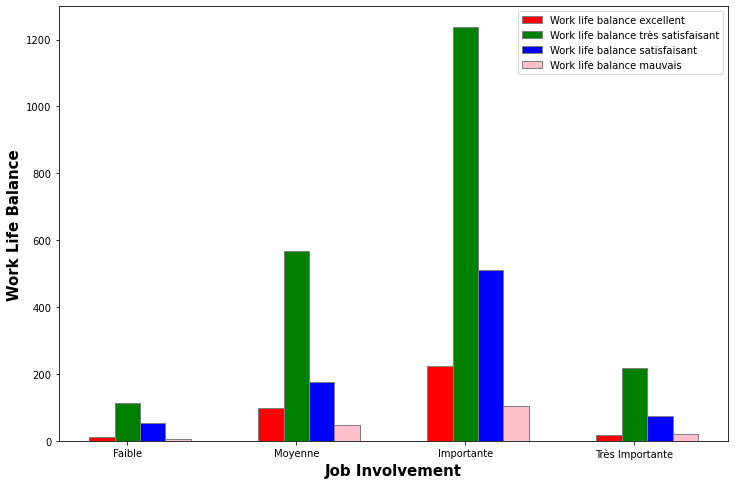

In [98]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
WorkLifeBalance_excellent = train_set["JobInvolvement"].loc[train_set["WorkLifeBalance"] == 4.0].value_counts().sort_index(ascending=True)
WorkLifeBalance_tres_satisfaisant = train_set["JobInvolvement"].loc[train_set["WorkLifeBalance"] == 3.0].value_counts().sort_index(ascending=True)
WorkLifeBalance_satisfaisant = train_set["JobInvolvement"].loc[train_set["WorkLifeBalance"] == 2.0].value_counts().sort_index(ascending=True)
WorkLifeBalance_mauvais = train_set["JobInvolvement"].loc[train_set["WorkLifeBalance"] == 1.0].value_counts().sort_index(ascending=True)

# Set position of bar on X axis 
br1 = np.arange(len(WorkLifeBalance_excellent)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
 
# Make the plot
plt.bar(br1, WorkLifeBalance_excellent, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Work life balance excellent') 
plt.bar(br2, WorkLifeBalance_tres_satisfaisant, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Work life balance très satisfaisant') 
plt.bar(br3, WorkLifeBalance_satisfaisant, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Work life balance satisfaisant')
plt.bar(br4, WorkLifeBalance_mauvais, color ='pink', width = barWidth, 
        edgecolor ='grey', label ='Work life balance mauvais') 

# Adding Xticks 
plt.xlabel('Job Involvement', fontweight ='bold', fontsize = 15) 
plt.ylabel('Work Life Balance', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(WorkLifeBalance_excellent))], ['Faible', 'Moyenne', 'Importante', 'Très Importante'])
plt.legend()
plt.show() 

Validation de l'hypothèse 2 - Il existe une corrélation entre JobSatisfaction et EnvironmentSatisfaction

In [50]:
train_set["EnvironmentSatisfaction"].value_counts()

3.0    1082
4.0    1055
2.0     696
1.0     674
Name: EnvironmentSatisfaction, dtype: int64

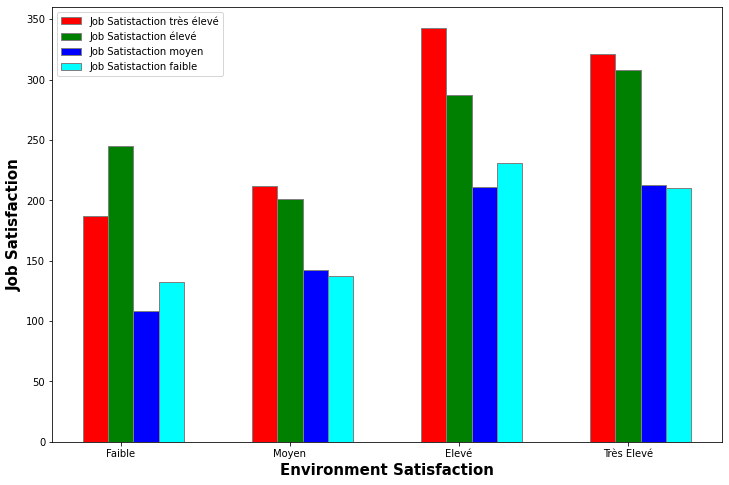

In [51]:
# set width of bar 
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
JobSatisfaction_treseleve = train_set["EnvironmentSatisfaction"].loc[train_set["JobSatisfaction"] == 4.0].value_counts().sort_index(ascending=True)
JobSatisfaction_eleve = train_set["EnvironmentSatisfaction"].loc[train_set["JobSatisfaction"] == 3.0].value_counts().sort_index(ascending=True)
JobSatisfaction_moyen = train_set["EnvironmentSatisfaction"].loc[train_set["JobSatisfaction"] == 2.0].value_counts().sort_index(ascending=True)
JobSatisfaction_faible = train_set["EnvironmentSatisfaction"].loc[train_set["JobSatisfaction"] == 1.0].value_counts().sort_index(ascending=True)

# Set position of bar on X axis 
br1 = np.arange(len(JobSatisfaction_treseleve)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
 
# Make the plot
plt.bar(br1, JobSatisfaction_treseleve, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Job Satistaction très élevé') 
plt.bar(br2, JobSatisfaction_eleve, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Job Satistaction élevé') 
plt.bar(br3, JobSatisfaction_moyen, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Job Satistaction moyen')
plt.bar(br4, JobSatisfaction_faible, color ='cyan', width = barWidth, 
        edgecolor ='grey', label ='Job Satistaction faible') 
 
# Adding Xticks 
plt.xlabel('Environment Satisfaction', fontweight ='bold', fontsize = 15) 
plt.ylabel('Job Satisfaction', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(JobSatisfaction_treseleve))], ['Faible', 'Moyen', 'Elevé', 'Très Elevé'])
 
plt.legend()
plt.show() 

# 2. Choix d'un modèle de machine learning

Pour rappel, nôtre objectif est de proposer un model permettant de déterminer si un employée est susceptible de quitter ou non l'entreprise. Nous sommes donc à la recherche d'un modèle de classification binaire. 

Pour choisir / trouver le modèle le plus adapté à notre problème, nous allons dans un premier temps tester les modèles que nous avons vus lors de notre formation, puis nous allons suivre les recommendations de la librairie `Scikit-Learn` via le schéma ci-dessous :

<center> <img src="images/scikit-learn schema.png" width="800"/> </center>

### LogisticRegression :

<center> <img src="images/LogisticRegression.png" width="600"/> </center>

La regression logistique est un algorithme de classification utilisé pour trouver la probabilité de succès et d'échec d'un événement. Il est utilisé lorsque le label est de nature binaire (0/1, Vrai / Faux, Oui / Non).

Dans la régression logistique, ce n’est pas la réponse binaire (malade/pas malade par exemple) qui est directement modélisée, mais la probabilité de réalisation d’une des deux modalités (être malade par exemple).
Cette probabilité de réalisation ne peut pas être modélisée par une droite car celle-ci conduirait à des valeurs <0 ou >1. Ce qui est impossible puisqu’une probabilité est forcément bornée par 0 et 1.

Cette probabilité, est alors modélisée par une courbe sigmoïde, bornée par 0, et 1

Avantages :
* S'étendre à plusieurs classes 
* Ne nécessite pas une puissance de calcul élevée
* Temps d'apprentissage inférieur à la plupart des autres algorithmes
* Variance est faible
* Facilement mis à jour avec de nouvelles données via descente de gradient stochastique.

Inconvénients :
* Problèmes non linéaires ne peuvent pas être résolus 
* Ne gère pas bien un grand nombre de variables catégorielles
* Sensible aux valeurs aberrantes
* Nécessite un vaste ensemble de données

In [52]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(train_set_features_prepared, train_set_labels)

LogisticRegression(random_state=42)

### Perceptron :
<center> <img src="images/Perceptron.png" width="600"/> </center>

Le perceptron est un algorithme d'apprentissage supervisé de classifieurs binaires (c'est-à-dire séparant deux classes). Si le problème est linéairement séparable, un théorème assure que la règle du perceptron permet de trouver une séparatrice entre les deux classes.

Le perceptron peut être vu comme le type de réseau de neurones le plus simple. C'est un classifieur linéaire. Ce type de réseau neuronal ne contient aucun cycle. Dans sa version simplifiée, le perceptron est mono-couche et n'a qu'une seule sortie (booléenne) à laquelle toutes les entrées (booléennes) sont connectées.

In [53]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(random_state=42)
perceptron.fit(train_set_features_prepared, train_set_labels)

Perceptron(random_state=42)

### DecisionTreeClassifier :

<center> <img src="images/DecisionTreeClassifier.png" width="600"/> </center>

L’apprentissage par arbre de décision désigne une méthode basée sur l'utilisation d'un arbre de décision comme modèle prédictif.

Dans ces structures d'arbre, les feuilles représentent les valeurs de la variable-cible et les embranchements correspondent à des combinaisons de variables d'entrée qui mènent à ces valeurs. En analyse de décision, un arbre de décision peut être utilisé pour représenter de manière explicite les décisions réalisées et les processus qui les amènent. En apprentissage et en fouille de données, un arbre de décision décrit les données mais pas les décisions elles-mêmes, l'arbre serait utilisé comme point de départ au processus de décision.

C'est une technique d'apprentissage supervisé : on utilise un ensemble de données pour lesquelles on connaît la valeur de la variable-cible afin de construire l'arbre (données dites étiquetées), puis on extrapole les résultats à l'ensemble des données de test.

Avantages :
* Il est simple à comprendre - résultat interprétable : on aura donc aura donc plus de "maitrise" sur cette algorithme
* Temps d'execution raisonnable

Inconvénients :
* Risque de sur-apprentissage (Overfitting) Pour atténuer ce défaut, on peut utiliser des ensembles d'arbres, comme des forêts aléatoires (RandomForest).

In [54]:
from sklearn import tree

decision_tree_clas = tree.DecisionTreeClassifier()
decision_tree_clas.fit(train_set_features_prepared, train_set_labels)

DecisionTreeClassifier()

### LinearSVC

<center> <img src="images/LinearSVC.png" width="600"/> </center>

Les machines à vecteurs de support (SVM : Support Vector Machines) sont une classe de méthodes d’apprentissage statistique basées sur le principe de la maximisation de la marge (séparation des classes). SVC est une méthode similaire qui s'appuie également sur les fonctions du noyau mais convient à l'apprentissage non supervisé. 

Il existe plusieurs formulations (linéaires, versions à noyaux) qui peuvent s’appliquer sur des données séparables (linéairement) mais aussi sur des données non séparables. Dans notre cas nous avons choisi de tester une formulation linéaire : le LinearSVC.

Les avantages des SVM :

* Très efficaces en dimension élevée.
* Ils sont aussi efficaces dans le cas où la dimension de l’espace est plus grande que le nombre d’échantillons d’apprentissage.
* Pour la décision, ils n’utilisent pas tous les échantillons d’apprentissage, mais seulement une partie (les vecteurs de support). En conséquence, ces algorithmes demandent moins de mémoire.

Désavantages :

* Si le nombre d’attributs est beaucoup plus grand que le nombre d’échantillons, les performances sont moins bonnes.
* Comme il s’agit de méthodes de discrimination entre les classes, elles ne fournissent pas d’estimations de probabilités

In [55]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(random_state=42, max_iter=5000)
lin_svc.fit(train_set_features_prepared, train_set_labels)

LinearSVC(max_iter=5000, random_state=42)

### GaussianNB

Le modèle "Gaussian Naive Bayes" 

La "méthode des k plus proches voisins" est un algorithme de classification non supervisé qui se base sur la classe des voisins d'une entrée. L'objet en entrée est classifié selon le résultat majoritaire des classes d'appartenance de ses k plus proches voisins (on choisi généralement un k assez faible).

Avantages :

* Facile à comprendre et à implémenter
* Modèle pouvant être facilement entrainé, même avec un faible jeu de données
* Rapide

Inconvénients :

* Considère chaque caractéristique est indépendente des autres, ce qui est rarement le cas.

In [56]:
from sklearn.naive_bayes import GaussianNB
gaus_nb = GaussianNB()
gaus_nb.fit(train_set_features_prepared, train_set_labels)

GaussianNB()

### KNeighborsClassifier :

<center> <img src="images/KNeighborsClassifier.png" width="600"/> </center>

La "méthode des k plus proches voisins" est un algorithme de classification non supervisé qui se base sur la classe des voisins d'une entrée. L'objet en entrée est classifié selon le résultat majoritaire des classes d'appartenance de ses k plus proches voisins (on choisi généralement un k assez faible).

Avantages :
* Facile à implémenter pour des problèmes multi-classes ;
* Flexibilité sur les critère de distance :
    1. Distance euclidienne
    2. Distance de Hamming
    3. Distance de Minkowski
    4. Distance de Manhattan
* Modèle intuitif et simple ;
* Pas d'étape d'apprentissage (dû à l'étiquetage à partir de la classe de ses voisins).

Inconvénients :
* Algorithme lent à mesure que le jeu de données augmente ;
* Les caractéristiques (features) doivent être homogènes ;
* Optimisation du nombre de voisins complexe ;
* Traitement des valeurs manquantes intrinsèquement impossible.

In [57]:
from sklearn.neighbors import KNeighborsClassifier
k_neigh_clas = KNeighborsClassifier(n_neighbors=3)
k_neigh_clas.fit(train_set_features_prepared, train_set_labels)

KNeighborsClassifier(n_neighbors=3)

### SVC :

<center> <img src="images/SVC.png" width="600"/> </center>

Les machines à vecteurs de support ou séparateurs à vaste marge (en anglais support vector machine, SVM) sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. Les SVM sont une généralisation des classifieurs linéaires.

In [58]:
from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(train_set_features_prepared, train_set_labels)

SVC(random_state=42)

### RandomForestClassifier :

L'apprentissage par "forêts d'arbres décisionnels" désigne un modèle de Machine Learning supervisé qui construit un ensemble d'arbres de décisions. Cet ensemble est finalement fusionné afin d'obtenir une prédiction plus précise et stable comparé à l'usage d'un seul arbre de décision dans la résolution d'un problème.

Avantages :

* Efficace avec des structures de données non-linéaires ;
* Efficace avec un grand jeu de données ;
* Faible risque de surapprentissage ;
* Meilleure précision (accuracy) que les autres algorithmes de classification.
* Peut résoudre des problèmes de classification ainsi que de régression ;
* Robuste aux valeurs aberrantes ;
* Supporte automatiquement les erreurs et données manquantes.

Inconvénients :

* Biaisé par des variables catégorielles ;
* Complexe à paramétrer de façon optimale ;
* Entrainement lent ;
* Limité pour la régression.


In [59]:
from sklearn.ensemble import RandomForestClassifier
forest_clas = RandomForestClassifier(random_state=42)
forest_clas.fit(train_set_features_prepared, train_set_labels)

RandomForestClassifier(random_state=42)

# 3. Mesure de la performance : Courbe ROC

### A. Introduction

Pour mesurer la performance de nos différents classifieur binaire, nous allons utiliser la `courbe en ROC` (Receiver Operating Characteristic). Cette courbe représente la sensibilité en fonction de (1 - spécificité). Plus en détails, cette courbe confronte le "taux de vrai positif" (_recall_) au "taux de faux positif"

Pour rappel :

* Un vrai positif est un résultat où le modèle prédit correctement la classe positive. De façon analogue, un vrai négatif est un résultat où le modèle prédit correctement la classe négative.

* Un faux positif est un résultat où le modèle prédit incorrectement la classe positive. Et un faux négatif est un résultat où le modèle prédit incorrectement la classe négative.



* Le taux de vrai positif est le ratio de positifs correctement classé, sa formule est :

$$
TPR = \frac{TP}{TP+FN}
$$

* Le taux de faux positif est le ratio de positifs incorrectement classé, sa formule est :

$$
FPR = \frac{FP}{TN+FP}
$$

### B. Récupération des décisions de chaque modèle

In [60]:
from sklearn.model_selection import cross_val_predict

#### B.1 Prédiction par cross validation

Attention, nous avons deux méthode de prédiction selon le model utilisé. 

##### Prédiction sur décision

In [61]:
#LogisticRegression
logistic_reg_score = cross_val_predict(logistic_reg, train_set_features_prepared,
                             train_set_labels, cv=5, method="decision_function")

#Perceptron
perceptron_score = cross_val_predict(perceptron, train_set_features_prepared,
                             train_set_labels, cv=5, method="decision_function")

#LinearSVC
lin_svc_score = cross_val_predict(lin_svc, train_set_features_prepared,
                             train_set_labels, cv=5, method="decision_function")

#SVC
svc_score = cross_val_predict(svc, train_set_features_prepared,
                             train_set_labels, cv=5, method="decision_function")

##### Prédiction sur probabilité

In [62]:
#DecisionTreeClassifier
decision_tree_clas_score = cross_val_predict(decision_tree_clas, train_set_features_prepared,
                                      train_set_labels, cv=5, method="predict_proba")

#GaussianNB
gaus_nb_score = cross_val_predict(gaus_nb, train_set_features_prepared,
                                      train_set_labels, cv=5, method="predict_proba")

#KNeighborsClassifier
k_neigh_clas_score = cross_val_predict(k_neigh_clas, train_set_features_prepared,
                                      train_set_labels, cv=5, method="predict_proba")

#RandomForestClassifier
forest_clas_score = cross_val_predict(forest_clas, train_set_features_prepared,
                                      train_set_labels, cv=5, method="predict_proba")

Nous representons en dataframe l'un de ces résultats, ici le `RandomForestClassifier`:

In [63]:
forest_clas_score_pd = pd.DataFrame(data=forest_clas_score)
forest_clas_score_pd.head()

,0,1
0,0.93,0.07
1,0.93,0.07
2,0.10,0.90
3,0.13,0.87
4,0.95,0.05


Il nous faut calculer un score. Nous allons considérer la probabilité de la classe positive (deuxième colonne)

In [64]:
decision_tree_clas_score = np.delete(decision_tree_clas_score, 0, axis=1)
gaus_nb_score = np.delete(gaus_nb_score, 0, axis=1)
k_neigh_clas_score = np.delete(k_neigh_clas_score, 0, axis=1)
forest_clas_score = np.delete(forest_clas_score, 0, axis=1)

#### B.2 Récupération des courbes ROC

In [65]:
from sklearn.metrics import roc_curve

In [66]:
#LogisticRegression
fpr_logistic_reg, tpr_logistic_reg, thresholds_logistic_reg = roc_curve(train_set_labels, logistic_reg_score)

#Perceptron
fpr_perceptron, tpr_perceptron, thresholds_perceptron = roc_curve(train_set_labels, perceptron_score)

#DecisionTreeClassifier
fpr_decision_tree_clas, tpr_decision_tree_clas, thresholds_decision_tree_clas = roc_curve(train_set_labels, decision_tree_clas_score)

#LinearSVC
fpr_lin_svc, tpr_lin_svc, thresholds_lin_svc = roc_curve(train_set_labels, lin_svc_score)

#GaussianNB
fpr_gaus_nb, tpr_gaus_nb, thresholds_gaus_nb = roc_curve(train_set_labels, gaus_nb_score)

#KNeighborsClassifier
fpr_k_neigh_clas, tpr_k_neigh_clas, thresholds_k_neigh_clas = roc_curve(train_set_labels, k_neigh_clas_score)

#SVC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(train_set_labels, svc_score)

#RandomForestClassifier
fpr_forest_clas, tpr_forest_clas, thresholds_forest_clas = roc_curve(train_set_labels, forest_clas_score)

#### B.3 Fonction d'affichage d'une courbe ROC

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

#### B.4 Affichage des courbes ROC

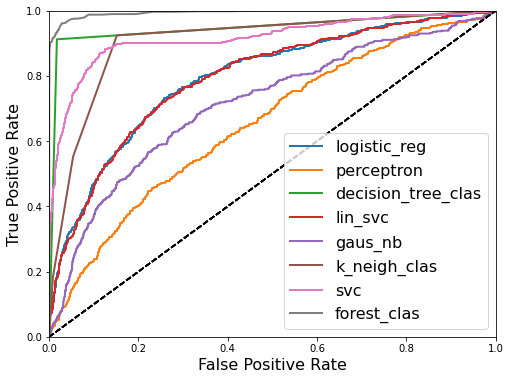

In [68]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_logistic_reg, tpr_logistic_reg, "logistic_reg")
plot_roc_curve(fpr_perceptron, tpr_perceptron, "perceptron")
plot_roc_curve(fpr_decision_tree_clas, tpr_decision_tree_clas, "decision_tree_clas")
plot_roc_curve(fpr_lin_svc, tpr_lin_svc, "lin_svc")
plot_roc_curve(fpr_gaus_nb, tpr_gaus_nb, "gaus_nb")
plot_roc_curve(fpr_k_neigh_clas, tpr_k_neigh_clas, "k_neigh_clas")
plot_roc_curve(fpr_svc, tpr_svc, "svc")
plot_roc_curve(fpr_forest_clas, tpr_forest_clas, "forest_clas")
plt.legend(loc="lower right", fontsize=16)
plt.show()

##### Remarques :

La courbe `ROC` est un indicateur permettant de mesurer la performance d'un modèle de prédiction. (les paramètres sont variables selon l'objectif à prédire). Ici on utilise le taux de Vrai Positif (bonne "vrai" prédiction par le modèle - Attrition à Yes dans notre cas) et le taux de faux positif (le modèle à prédit Yes mais celui-ci s'est trompé). On cherche donc un modèle qui maximise le `TPR` et qui miniminise le `FPR` (on ne souhaite pas d'un modèle qui prédise qu'un l'employé à l'intention de partir alors que se n'est pas du tout le cas).

Nous souhaitons donc garder le modèle dont la courbe `ROC` se rapproche le plus possible de l'axe des ordonnées (TPR).On souhaite que la courbe `ROC` possède un point qui maximise au mieux le rapport `TPR/FPR`.

Apres analyse des différentes courbes `ROC` de chaque modèle on remarque deux canditats qui se distinguent et possèdent des performances très proche ("point optimal très proche") : Le `Random Forest Classifier` et le `Decision Tree Classifier`.
Nous retiendrons donc pour la suite ces deux modèles et nous les départagerons apres variations de leurs hyperparamètres  

#### Calculs des scores de chaque modèle :

In [69]:
from sklearn.metrics import roc_auc_score
roc_score_logistic_reg = roc_auc_score(train_set_labels, logistic_reg_score)
roc_score_perceptron = roc_auc_score(train_set_labels, perceptron_score)
roc_score_lin_svc = roc_auc_score(train_set_labels, lin_svc_score)
roc_score_gaus_nb = roc_auc_score(train_set_labels, gaus_nb_score)
roc_score_k_neigh_clas = roc_auc_score(train_set_labels, k_neigh_clas_score)
roc_score_svc = roc_auc_score(train_set_labels, svc_score)
roc_score_forest_clas = roc_auc_score(train_set_labels, forest_clas_score)
roc_score_decision_tree_clas = roc_auc_score(train_set_labels, decision_tree_clas_score)

In [70]:
print("logistic_reg : ", roc_score_logistic_reg)
print("perceptron : ", roc_score_perceptron)
print("lin_svc : ", roc_score_lin_svc)
print("gaus_nb : ", roc_score_gaus_nb)
print("k_neigh_clas : ", roc_score_k_neigh_clas)
print("svc : ", roc_score_svc)
print("forest_clas : ", roc_score_forest_clas)
print("decision_tree_clas : ", roc_score_decision_tree_clas)

logistic_reg :  0.7942745346329539
perceptron :  0.6529523879665327
lin_svc :  0.7935760608812531
gaus_nb :  0.7144148114447537
k_neigh_clas :  0.9061277411085658
svc :  0.9165157563443215
forest_clas :  0.9943528159598877
decision_tree_clas :  0.9474454926170255


#### Calcul de précision et recall des meilleurs modèles :

In [71]:
forest_clas_labels_pred = cross_val_predict(forest_clas, train_set_features_prepared, train_set_labels, cv=5)
decision_tree_clas_labels_pred = cross_val_predict(decision_tree_clas, train_set_features_prepared, train_set_labels, cv=5)

In [72]:
from sklearn.metrics import precision_score, recall_score
print("\nPrécision forest_clas :", precision_score(train_set_labels, forest_clas_labels_pred))
print("Recall forest_clas :", recall_score(train_set_labels, forest_clas_labels_pred))

print("\nPrécision decision_tree_clas :", precision_score(train_set_labels, decision_tree_clas_labels_pred))
print("Recall decision_tree_clas :", recall_score(train_set_labels, decision_tree_clas_labels_pred))


Précision forest_clas : 0.9941060903732809
Recall forest_clas : 0.8892794376098418

Précision decision_tree_clas : 0.9050966608084359
Recall decision_tree_clas : 0.9050966608084359


# 3. Paramétrage des meilleurs modèles : RandomizedSearchCV

Nos deux meilleurs modèles étant maintenant choisit, nous allons chercher le meilleur paramétrage pour ceux-ci.

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

### A. RandomForestClassifier

In [74]:
param_distribs_forest_clas = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_clas_param = RandomizedSearchCV(forest_clas, param_distribs_forest_clas, cv=5,
                           scoring='roc_auc', n_iter=10, return_train_score=True)

forest_clas_param.fit(train_set_features_prepared, train_set_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E94B54A88>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020E94B54608>},
                   return_train_score=True, scoring='roc_auc')

In [75]:
best_estimator_forest_clas = forest_clas_param.best_estimator_
best_estimator_forest_clas

RandomForestClassifier(max_features=3, n_estimators=135, random_state=42)

### B. DecisionTreeClassifier

In [76]:
param_distribs_decision_tree_clas = {
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(1, 100),}

decision_tree_clas_param = RandomizedSearchCV(decision_tree_clas, param_distribs_decision_tree_clas, cv=5,
                            scoring='roc_auc', n_iter=10, return_train_score=True)

decision_tree_clas_param.fit(train_set_features_prepared, train_set_labels)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   return_train_score=True, scoring='roc_auc')

In [77]:
best_estimator_decision_tree_clas = decision_tree_clas_param.best_estimator_
best_estimator_decision_tree_clas

DecisionTreeClassifier(max_depth=35)

# 4. Test des modèles

Nos deux modèles sont maintenant prêt à être testés sur le `test_set`. Nous allons dans un premier temps isoler la donnée "recherchée" du test_set, à savoir `Attrition` puis nous allons appliquer notre pipeline de transformation de données sur nos `features`.

In [78]:
test_set_features = test_set.drop("Attrition", axis=1)
test_set_labels = test_set["Attrition"].copy()
test_set_features_prepared = full_pipeline.transform(test_set_features)

Affichons les scores qu'obtiennent nos modèles sur le `test_set`

In [79]:
print("forest_clas_best_score : ", best_estimator_forest_clas.score(test_set_features_prepared, test_set_labels))
print("decision_tree_clas_best_score : ", best_estimator_decision_tree_clas.score(test_set_features_prepared, test_set_labels))

forest_clas_best_score :  0.9965986394557823
decision_tree_clas_best_score :  0.9954648526077098


Wow 99% de réussite, ce sonbt de très bon score. Affichons maintenant les matrices de confusion pour le `test_set`.

#### Matrices de confusions des tests :

In [80]:
from sklearn.metrics import confusion_matrix

forest_clas_test_set_labels_pred = best_estimator_forest_clas.predict(test_set_features_prepared)
decision_tree_clas_test_set_labels_pred = best_estimator_decision_tree_clas.predict(test_set_features_prepared)

In [81]:
conf_mx_forest_clas = confusion_matrix(test_set_labels, forest_clas_test_set_labels_pred)
conf_mx_forest_clas_pd = pd.DataFrame(data=conf_mx_forest_clas)
print("conf_mx_forest_clas : ")
conf_mx_forest_clas_pd

conf_mx_forest_clas : 


,0,1
0,740,0
1,3,139


Grace à cette matrice, nous voyons que notre modèle a prédit que 3 personnes n'allaient pas partir, alors que c'est le cas. Cette matrice est donc plutôt bonne car nous avions au total 142 personnes qui sont parties

In [82]:
conf_mx_decision_tree_clas = confusion_matrix(test_set_labels, decision_tree_clas_test_set_labels_pred)
conf_mx_decision_tree_clas_pd = pd.DataFrame(data=conf_mx_decision_tree_clas)
print("conf_mx_decision_tree_clas : ")
conf_mx_decision_tree_clas_pd

conf_mx_decision_tree_clas : 


,0,1
0,740,0
1,4,138


Ainsi, le meilleur modèle de prédiction correspondant au problème de l'entreprise est le `RandomForestClassifier`

# 5. Étude des résultats

In [83]:
feature_importances_forest_clas = best_estimator_forest_clas.feature_importances_
feature_importances_forest_clas

array([0.0783544 , 0.05185208, 0.02868259, 0.02700877, 0.0639132 ,
       0.04290846, 0.04493957, 0.02487764, 0.06837729, 0.03119691,
       0.05883906, 0.03324417, 0.04574247, 0.02593256, 0.00867996,
       0.03677723, 0.03272577, 0.02834121, 0.09378335, 0.00549564,
       0.01720003, 0.01157816, 0.00734745, 0.01053287, 0.0099161 ,
       0.0055249 , 0.01228656, 0.00609319, 0.01090779, 0.00474223,
       0.00520978, 0.00645384, 0.00385086, 0.00986002, 0.00512201,
       0.00549485, 0.00688589, 0.01036129, 0.01298208, 0.00597776])

In [84]:
sorted(zip(feature_importances_forest_clas, train_set_features_num + train_set_features_cat), reverse=True)

[(0.09378335020298034, 'MoyenneInOut'),
 (0.07835439850999798, 'Age'),
 (0.0683772871388814, 'TotalWorkingYears'),
 (0.06391320281397979, 'MonthlyIncome'),
 (0.058839060291132686, 'YearsAtCompany'),
 (0.05185207560108591, 'DistanceFromHome'),
 (0.04574246541986188, 'YearsWithCurrManager'),
 (0.04493957279094734, 'PercentSalaryHike'),
 (0.04290846430371483, 'NumCompaniesWorked'),
 (0.03677722595187007, 'EnvironmentSatisfaction'),
 (0.03324417334138926, 'YearsSinceLastPromotion'),
 (0.03272576748863334, 'JobSatisfaction'),
 (0.031196911225079758, 'TrainingTimesLastYear'),
 (0.028682591805719953, 'Education'),
 (0.02834121108710139, 'WorkLifeBalance'),
 (0.027008771308984242, 'JobLevel'),
 (0.02593256167661726, 'JobInvolvement'),
 (0.024877642230125847, 'StockOptionLevel'),
 (0.01720003234902339, 'BusinessTravel_Travel_Frequently'),
 (0.012982080961621905, 'JobRole_Sales Executive'),
 (0.012286564555585331, 'EducationField_Life Sciences'),
 (0.011578163059152057, 'BusinessTravel_Travel_Ra

On remarque que la feature `MoyenneInOut` est celle qui influence le plus `Attrition`. Etudions comment le temps de travail moyen sur l'année 2015 d'un salarié  impacte sa prise de décision concernant son choix de rester au sein de l'entreprise ou bien de partir pour l'année 2016. Nous comparons une variable binaire avec une variable discrète.

<AxesSubplot:xlabel='Attrition', ylabel='MonthlyIncome'>

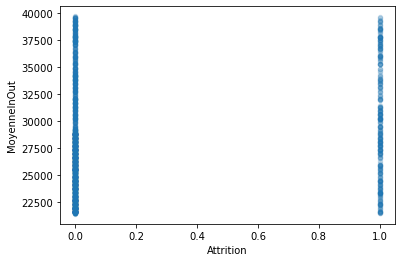

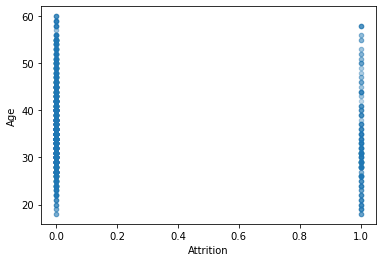

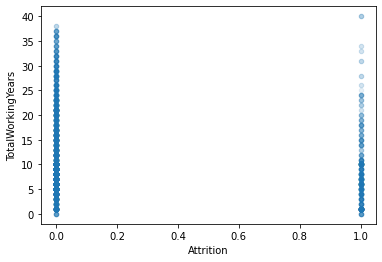

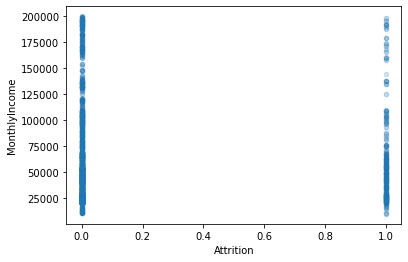

In [88]:
train_set.plot(kind="scatter", x="Attrition", y="MoyenneInOut", alpha=0.1,
    sharex=False)
train_set.plot(kind="scatter", x="Attrition", y="Age", alpha=0.1,
    sharex=False)
train_set.plot(kind="scatter", x="Attrition", y="TotalWorkingYears", alpha=0.1,
    sharex=False)
train_set.plot(kind="scatter", x="Attrition", y="MonthlyIncome", alpha=0.1,
    sharex=False)


Le label attrition étant binaire (Oui ou Non), le graphique est donc partagé en deux catégories

* 0 - le salarié souhaite continuer à travailler pour l'entreprise pour l'année 2016
* 1 - le salarié à décidé de partir de l'entreprise durant l'année 2016

Nous remarquons que le nombre d'employés ayant un temps de travail moyen sur une année important on beaucoup plus tendance à rester au sein de l'entreprise (concentration de points beaucoup plus important à des valeurs élevé de MoyenneInOut). Nous pouvons en conclure que lorsque le salarié effectue peu d'heures de travail, celui-ci a beaucoup plus tendance à quitter l'entreprise.